# Are signal lags necessary to explain the Doppler oscillations?

Necessity is tested by replacing the light-time lags by a constant. The m/s units enforced in `OrbitFitter.fit_doppler_data` are ensured by applying the lag computed at the first sample epoch to all sample epochs. The result is a slope instead of a steady oscillation, proving that the lag needs to be range proportional. 

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, find_swings

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + 30*u.day

In [2]:
sampling_interval = 600
sample_offsets = np.arange(0, (canberra_end-canberra_start)/(1*u.s), sampling_interval)
flyby_epochs = canberra_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 09:53:55.600 1998-02-22 09:43:55.600 [ 4320 ]


In [3]:
near_goldstone_ephem = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR)
near_goldstone_end_rv = near_goldstone_ephem.rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_extended_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 77530.78379128852 km 17867309.660458416 km
Start and end radial speeds: 7.3216176182785535 km / s 6.736573500105011 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.45792764757623844 deg


In [5]:
sim_meas = []
first_ref_ra = None

for e in flyby_epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_ra = dss34.range_rate_accel(rv, e)
    if first_ref_ra is None:
            first_ref_ra = ref_ra
    sim_meas.append([ref_rr - 0.1*first_ref_ra*ref_r/const.c])

print(sim_meas)

[[<Quantity 7.32161944 km / s>], [<Quantity 7.29522658 km / s>], [<Quantity 7.27059696 km / s>], [<Quantity 7.24763497 km / s>], [<Quantity 7.2262383 km / s>], [<Quantity 7.20630541 km / s>], [<Quantity 7.18773941 km / s>], [<Quantity 7.17044985 km / s>], [<Quantity 7.1543534 km / s>], [<Quantity 7.13937383 km / s>], [<Quantity 7.12544172 km / s>], [<Quantity 7.11249395 km / s>], [<Quantity 7.10047313 km / s>], [<Quantity 7.08932703 km / s>], [<Quantity 7.07900803 km / s>], [<Quantity 7.06947259 km / s>], [<Quantity 7.06068079 km / s>], [<Quantity 7.05259587 km / s>], [<Quantity 7.04518389 km / s>], [<Quantity 7.03841336 km / s>], [<Quantity 7.03225496 km / s>], [<Quantity 7.02668123 km / s>], [<Quantity 7.02166639 km / s>], [<Quantity 7.01718607 km / s>], [<Quantity 7.0132172 km / s>], [<Quantity 7.00973778 km / s>], [<Quantity 7.00672677 km / s>], [<Quantity 7.00416399 km / s>], [<Quantity 7.00202997 km / s>], [<Quantity 7.00030587 km / s>], [<Quantity 6.99897341 km / s>], [<Quantity

In [6]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_goldstone_orbit, [dss34], var=0.001, debug=True)

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_doppler_data(flyby_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss34)

-1. 16.898697 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 16.898697 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 16.898697 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 16.898697 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 16.898697 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
4. 16.898697 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.54005925499

In [8]:
print(fitter.result.residual)

[ 0.03538939  0.03349215  0.03145911 ... -0.44451563 -0.44483066
 -0.44514391]


The result indeed presents oscillations of similar magnitude, validating the signal lags hypothesis. The 3d visualization shows that the oscillations are entirely due to the lags and Earth rotation, as the trajectory itself is essentially linear and unchanged..

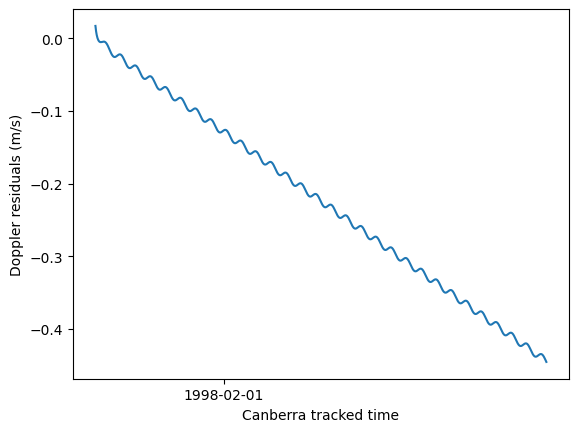

In [9]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Canberra tracked time')
    plt.ylabel('Doppler residuals (m/s)')
    plt.plot(flyby_epochs[10:], fitter.result.residual[10:])

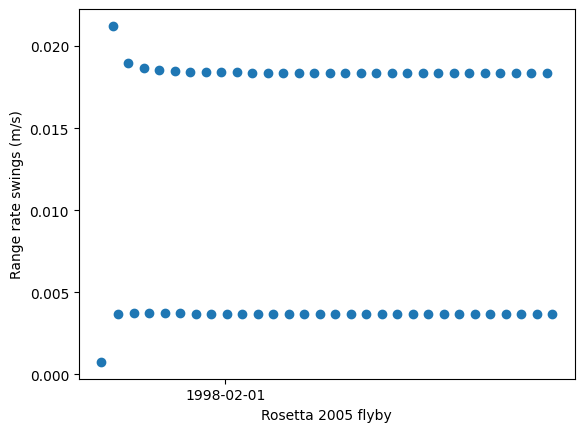

In [10]:
peak_epochs, peak_swings = find_swings(flyby_epochs, fitter.result.residual)
with visualization.time_support():
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate swings (m/s)')
    plt.scatter(peak_epochs, peak_swings)